**Deep Learning - Redes Recorrentes**

> 12/04/2024




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

[]


In [2]:
sns.set(style="darkgrid", font_scale=1.5)

In [3]:
register_matplotlib_converters()

Lendo o CSV e visualizando os dados. Como se tratam de dados temporais, utilizarmos a coluna "timestamp" como índice.

In [5]:
df = pd.read_csv("DLRedesRecorrentes\stock_data.csv", parse_dates=["timestamp"], index_col="timestamp")
df.shape

(1610, 11)

In [6]:
df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,1503014399999,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,1503100799999,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1503187199999,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,1503273599999,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,1503359999999,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970


Os dados contêm mais de 1600 linhas (uma para cada dia), e 11 colunas. Vamos remover todas as colunas exceto a coluna "close" (único dado de interesse)

In [7]:
df.drop('high', axis=1, inplace=True)
df.drop('low', axis=1, inplace=True)
df.drop('open', axis=1, inplace=True)
df.drop('volume', axis=1, inplace=True)
df.drop('close_time', axis=1, inplace=True)
df.drop('quote_av', axis=1, inplace=True)
df.drop('trades', axis=1, inplace=True)
df.drop('tb_base_av', axis=1, inplace=True)
df.drop('tb_quote_av', axis=1, inplace=True)
df.drop('ignore', axis=1, inplace=True)

#df['close'] = df['close'].pct_change() # mudaria para porcentagem de mudança
df.dropna(how='any', axis=0, inplace=True)

df.shape

(1610, 1)

In [8]:
df.tail()

,close
timestamp,
2022-01-08,41679.74
2022-01-09,41864.62
2022-01-10,41822.49
2022-01-11,42729.29
2022-01-12,43902.66


Vamos verificar os dados temporais plotados.

Text(0.5, 1.0, 'Variações de Preço')

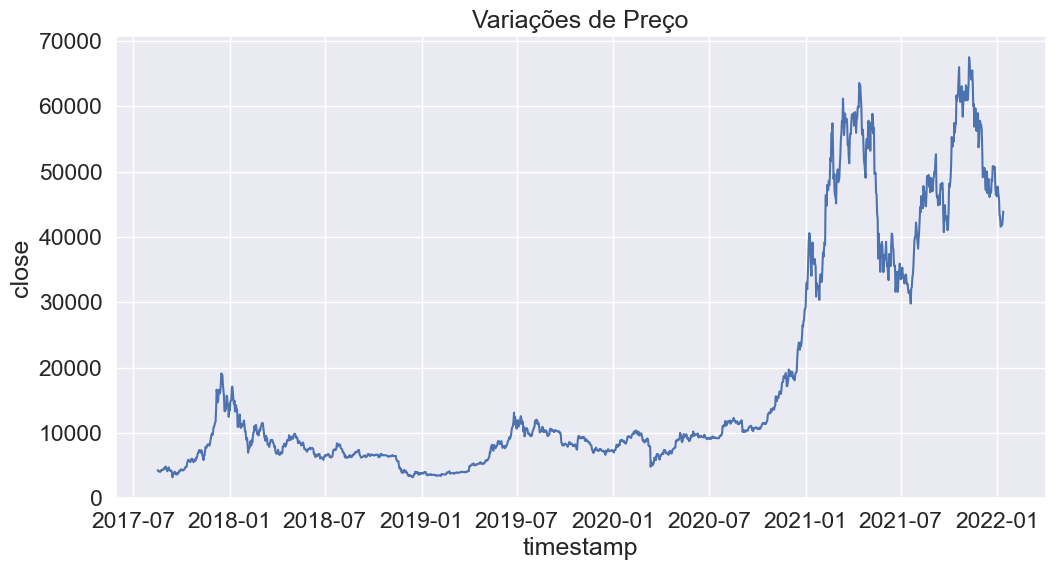

In [9]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="close", data=df).set_title("Variações de Preço")

Amortizando a visualização...

Text(0.5, 0.9, 'sub-amostragem para intervalos de 10 dias')

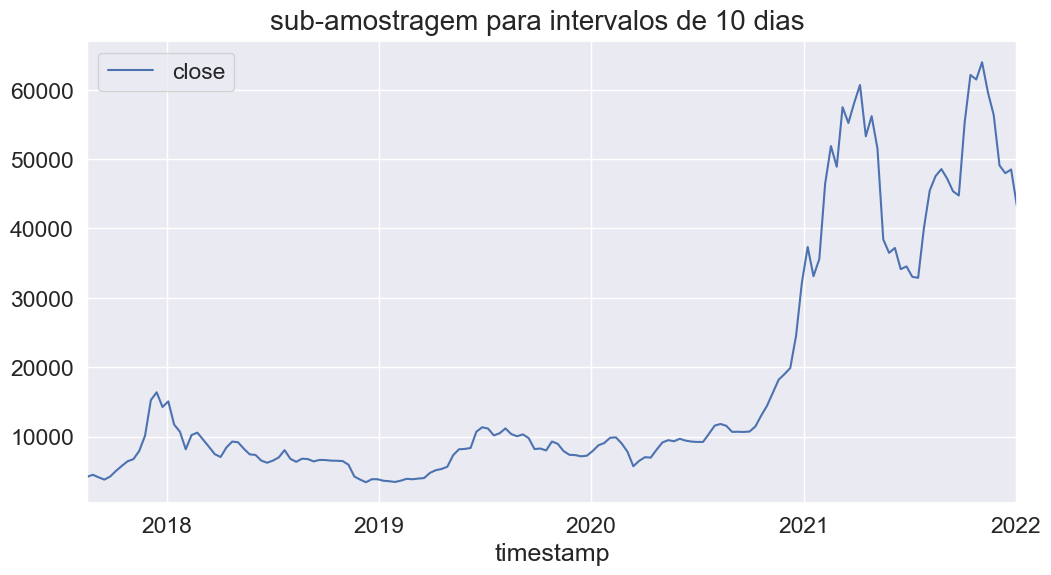

In [10]:
df.resample('10D').mean().plot(figsize=(12,6))
plt.figtext(.5,0.9,"sub-amostragem para intervalos de 10 dias", fontsize=20, ha='center')

# Model

Redes recorrentes são modelos poderosos para tratar sequências, pois eles mantêm o estado interno sobre as variações anteriores. Tais redes requerem uma matriz 3d com formato: (num_exemplos_treino, timesteps, input_dim).

Vamos construir um modelo usando timesteps=50 valores anteriores para prever o próximo valor. Como estamos usando apenas uma variável, input_dim=1.

## Pré-processamento dos dados
Reorganizando os dados de forma que uma sequencia de valores dos 50 dias anteriores seja usada para prever o próximo dia. Os valores também serão normalizados entre 0 e 1.

In [11]:
data = df.iloc[:, 0]
#data=df[['close', 'high', 'low']].to_numpy()
data

timestamp
2017-08-17     4285.08
2017-08-18     4108.37
2017-08-19     4139.98
2017-08-20     4086.29
2017-08-21     4016.00
                ...   
2022-01-08    41679.74
2022-01-09    41864.62
2022-01-10    41822.49
2022-01-11    42729.29
2022-01-12    43902.66
Name: close, Length: 1610, dtype: float64

In [12]:
hist = []
target = []
length = 20

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]

    hist.append(x)
    target.append(y)

C:\Users\Lucri\AppData\Local\Temp\ipykernel_25788\220504212.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = data[i+length]


In [13]:
print(len(hist[0]))
print(len(hist))
print(len(target))

20
1590
1590


In [14]:
print(hist[0])

timestamp
2017-08-17    4285.08
2017-08-18    4108.37
2017-08-19    4139.98
2017-08-20    4086.29
2017-08-21    4016.00
2017-08-22    4040.00
2017-08-23    4114.01
2017-08-24    4316.01
2017-08-25    4280.68
2017-08-26    4337.44
2017-08-27    4310.01
2017-08-28    4386.69
2017-08-29    4587.48
2017-08-30    4555.14
2017-08-31    4724.89
2017-09-01    4834.91
2017-09-02    4472.14
2017-09-03    4509.08
2017-09-04    4100.11
2017-09-05    4366.47
Name: close, dtype: float64


In [15]:
print(target[0])

4619.77


In [16]:
print(hist[1])

timestamp
2017-08-18    4108.37
2017-08-19    4139.98
2017-08-20    4086.29
2017-08-21    4016.00
2017-08-22    4040.00
2017-08-23    4114.01
2017-08-24    4316.01
2017-08-25    4280.68
2017-08-26    4337.44
2017-08-27    4310.01
2017-08-28    4386.69
2017-08-29    4587.48
2017-08-30    4555.14
2017-08-31    4724.89
2017-09-01    4834.91
2017-09-02    4472.14
2017-09-03    4509.08
2017-09-04    4100.11
2017-09-05    4366.47
2017-09-06    4619.77
Name: close, dtype: float64


In [17]:
print(hist[0][length-1])
print(data[length-1])

4366.47
4366.47


C:\Users\Lucri\AppData\Local\Temp\ipykernel_25788\3876518160.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hist[0][length-1])
C:\Users\Lucri\AppData\Local\Temp\ipykernel_25788\3876518160.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data[length-1])


o último ponto do exemplo de treino 1 (hist\[1\]) é a rotulação do exemplo de treino 0 e o elemento length do dado original. double check:

In [18]:
print(hist[1][length-1])
print(data[length])
print(target[0])

4619.77
4619.77
4619.77


C:\Users\Lucri\AppData\Local\Temp\ipykernel_25788\274620363.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hist[1][length-1])
C:\Users\Lucri\AppData\Local\Temp\ipykernel_25788\274620363.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data[length])


In [20]:
print(type(hist), type(target))

<class 'list'> <class 'list'>


In [21]:
#convertendo de lista para array
hist = np.array(hist)
target = np.array(target)

In [22]:
print(type(hist), type(target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [23]:
hist.shape

(1590, 20)

In [24]:
target.shape

(1590,)

In [25]:
target = target.reshape(-1,1)
target.shape

(1590, 1)

In [26]:
#Forma correta de normalizar com MinMax (fazendo a divisão entre treino e validação)

valued=int(hist.shape[0]*9/10)
print(valued)

X_train = hist[:valued,:]
X_val = hist[valued:,:]

y_train = target[:valued,:]
y_val = target[valued:,:]

##Normalizando...
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

X_train = X_train.reshape((len(X_train), length, 1)) #array 3d (entrada do LSTM). A terceira dimensão tem apenas 1 feature.
X_val = X_val.reshape((len(X_val), length, 1))

sc.fit(y_train)
y_train = sc.transform(y_train)
y_val = sc.transform(y_val)

1431


In [92]:
X_train.shape

(1431, 20, 1)

## Construindo a rede neural

In [84]:
model = tf.keras.Sequential()

#model.add(SimpleRNN(25, return_sequences=True, input_shape=(length,1)))
model.add(SimpleRNN(25, input_shape=(length,1)))

model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 25)                675       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 701 (2.74 KB)
Trainable params: 701 (2.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Criamos um modelo com 1 camada de RNN e 1 camada densa de saída. Compilando e treinando o método...

In [85]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#checkpoint = ModelCheckpoint("best", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)


In [86]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32,  callbacks=[checkpoint])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32)

Epoch 1/30
45/45 [==============================] - 2s 10ms/step - loss: 9.3726e-04 - mae: 0.0199 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 2/30
45/45 [==============================] - 0s 5ms/step - loss: 5.1054e-04 - mae: 0.0133 - val_loss: 0.0018 - val_mae: 0.0333
Epoch 3/30
45/45 [==============================] - 0s 6ms/step - loss: 4.5554e-04 - mae: 0.0125 - val_loss: 0.0018 - val_mae: 0.0337
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 4.3429e-04 - mae: 0.0126 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 5/30
45/45 [==============================] - 0s 7ms/step - loss: 3.9455e-04 - mae: 0.0119 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 3.8015e-04 - mae: 0.0113 - val_loss: 0.0016 - val_mae: 0.0310
Epoch 7/30
45/45 [==============================] - 0s 7ms/step - loss: 4.0120e-04 - mae: 0.0119 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 8/30
45/45 [==============================] - 0s 6ms/st


Vamos visualizar os erros de treino e validação:



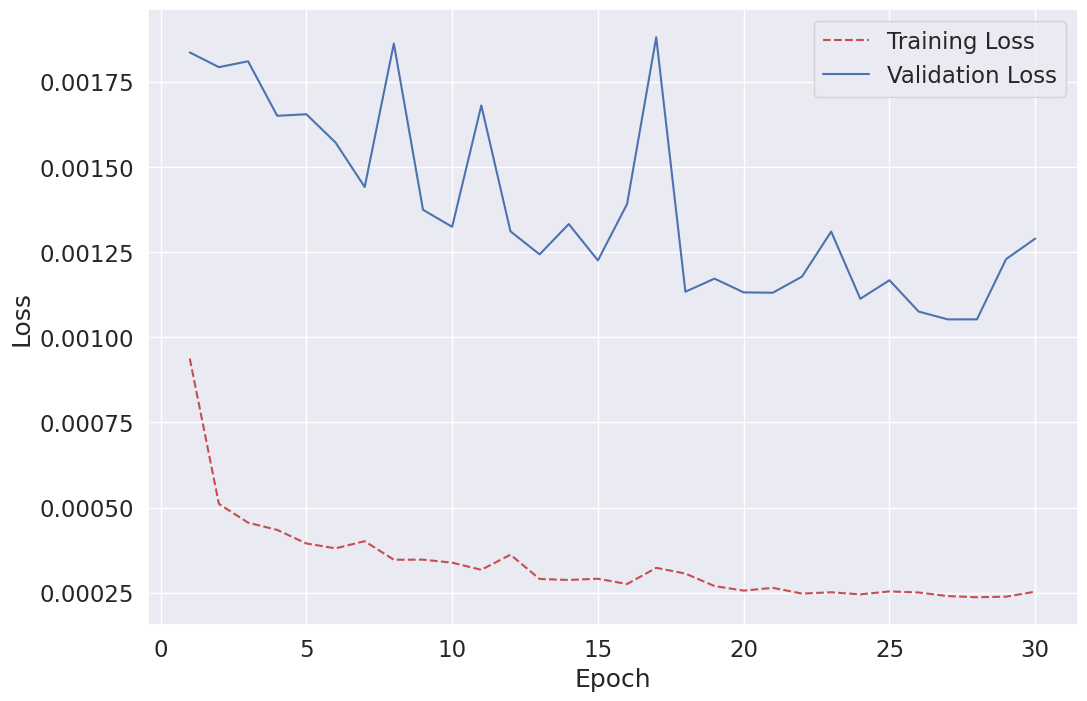

In [87]:
loss = history.history['loss']
val_loss=history.history['val_loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, val_loss,  )
plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Vamos fazer as predições:

In [88]:
pred = model.predict(X_val)
#print(np.hstack((pred, y_val)))


5/5 [==============================] - 0s 4ms/step


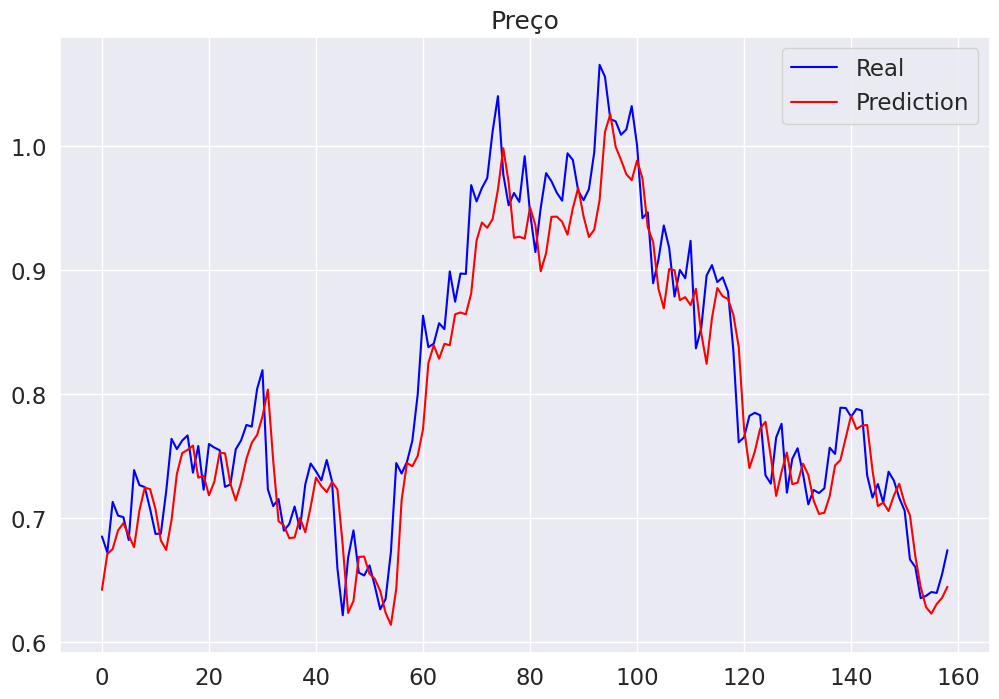

In [89]:
plt.figure(figsize=(12,8))
plt.plot(y_val, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Preço')
plt.legend()
plt.show()

O modelo parece estar bem ajustado. Vamos verificar o valor real (sem normalização):

In [90]:
pred_transformed = sc.inverse_transform(pred)
y_val_transformed = sc.inverse_transform(y_val)

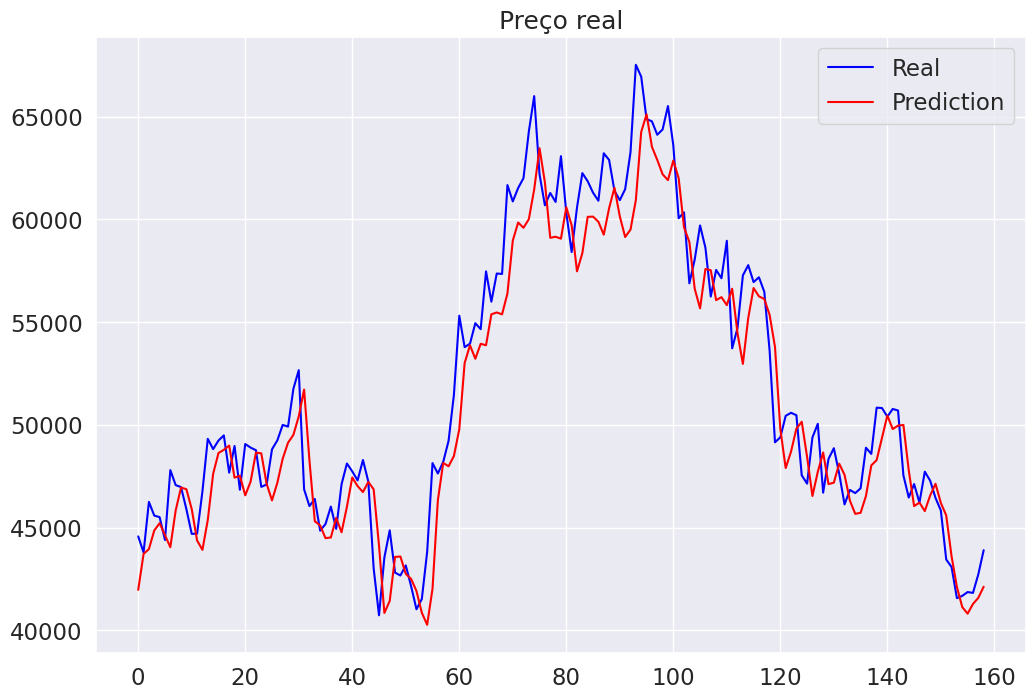

In [91]:
plt.figure(figsize=(12,8))
plt.plot(y_val_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Preço real')
plt.legend()
plt.show()